# Model V1

In [20]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F

Make reproducible

In [21]:
import torch
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import numpy as np
np.random.seed(0)

# Load the images

In [22]:
from torch.utils.data import Dataset
from skimage import io, transform
from PIL import Image

In [23]:
import pandas as pd
class ImageDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.images = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.root_dir+'/'+self.images.iloc[idx, 0]
        
        with Image.open(img_name) as image:
            if self.transform:
                image = self.transform(image)

        return (image, self.images.iloc[idx, 1])

In [26]:
image_folder = ImageDataset(csv_file='data/train.csv', root_dir='data/train_images', 
                           transform=transforms.Compose([transforms.Resize(200), 
                                                         transforms.ToTensor(),
                                                         #transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
                                                        ]))

In [27]:
len(image_folder)

21397

In [28]:
img1, class1 = image_folder[0]
img1.shape

torch.Size([3, 200, 266])

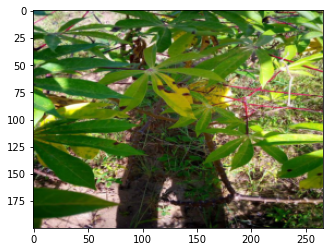

In [29]:
from matplotlib.pyplot import imshow
from torchvision import transforms
imshow(transforms.ToPILImage()(img1))

Add normalization

In [30]:
image_folder = ImageDataset(csv_file='data/train.csv', root_dir='data/train_images', 
                           transform=transforms.Compose([transforms.Resize(200), 
                                                         transforms.ToTensor(),
                                                         transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
                                                        ]))

## Define train and testsets

In [31]:
from torch.utils.data import random_split
N = len(image_folder)
train_dataset, test_dataset = random_split(image_folder, [int(N*0.8)+1, int(N*0.2)])

In [32]:
data_loader = torch.utils.data.DataLoader(train_dataset
    ,batch_size=25
    ,shuffle=True
    ,num_workers=3                                      
)

## Define the network

In [33]:
sample = next(iter(image_folder))
image, label = sample 
image.shape

torch.Size([3, 200, 266])

In [46]:
import torch.nn as nn
import torch.nn.functional as F

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        self.conv3 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=5)
        self.conv4 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=5)
        
        self.fc1 = nn.Linear(in_features=24 * 12 * 8, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=5)

    def forward(self, t):
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        
        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        
        t = self.conv3(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        
        t = self.conv4(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        
        #print(t.shape)
        t = t.reshape(-1, 24 * 12 * 8)
        t = self.fc1(t)
        t = F.relu(t)

        t = self.out(t)
        t = F.softmax(t, dim=1)
    
        return t

In [47]:
network = Network()
network.eval()

Network(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(12, 24, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(24, 24, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=2304, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=5, bias=True)
)

## Train the network

In [48]:
import torch.optim as optim
optimizer = optim.Adam(network.parameters(), lr=0.05)
from evaluate import get_num_correct

In [49]:
import time

for epoch in range(50):
    total_loss = 0
    total_correct = 0
    N = 0
    start_time = time.time()
    for batch in data_loader:
        images, labels = batch 

        preds = network(images)
        loss = F.cross_entropy(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        N += len(preds)
        total_loss += loss.item()
        total_correct += get_num_correct(preds, labels)
        if N%200==0:
            print(
            "epoch:", epoch, 
            "accuracy:", round(100 * total_correct/N), '%',
            "total_correct", total_correct,
            "loss:", total_loss,
            "duration:", time.time()-start_time, 's'
            )

epoch: 0 accuracy: 56 % total_correct 111 loss: 10.665518879890442 duration: 6.078622341156006 s
epoch: 0 accuracy: 56 % total_correct 225 loss: 21.344180703163147 duration: 11.341350555419922 s
epoch: 0 accuracy: 60 % total_correct 359 loss: 31.22284233570099 duration: 16.654796838760376 s
epoch: 0 accuracy: 60 % total_correct 482 loss: 41.54150331020355 duration: 22.00788688659668 s
epoch: 0 accuracy: 60 % total_correct 601 loss: 52.02016460895538 duration: 28.271994829177856 s
epoch: 0 accuracy: 60 % total_correct 719 loss: 62.53882563114166 duration: 34.399264097213745 s
epoch: 0 accuracy: 60 % total_correct 834 loss: 73.17748701572418 duration: 40.581016540527344 s
epoch: 0 accuracy: 60 % total_correct 958 loss: 83.45614802837372 duration: 46.72309732437134 s
epoch: 0 accuracy: 60 % total_correct 1089 loss: 93.45480966567993 duration: 53.104965686798096 s
epoch: 0 accuracy: 61 % total_correct 1226 loss: 103.21347105503082 duration: 59.65855956077576 s
epoch: 0 accuracy: 62 % total

epoch: 1 accuracy: 60 % total_correct 120 loss: 10.438661217689514 duration: 9.690036296844482 s
epoch: 1 accuracy: 64 % total_correct 257 loss: 20.197322726249695 duration: 17.750328063964844 s
epoch: 1 accuracy: 65 % total_correct 388 loss: 30.195984601974487 duration: 25.940059661865234 s
epoch: 1 accuracy: 63 % total_correct 506 loss: 40.714646100997925 duration: 34.02614974975586 s
epoch: 1 accuracy: 63 % total_correct 627 loss: 51.1133074760437 duration: 42.061243772506714 s
epoch: 1 accuracy: 62 % total_correct 744 loss: 61.671968936920166 duration: 50.09820032119751 s
epoch: 1 accuracy: 61 % total_correct 859 loss: 72.3106302022934 duration: 58.15211296081543 s
epoch: 1 accuracy: 61 % total_correct 980 loss: 82.70929145812988 duration: 66.19952034950256 s
epoch: 1 accuracy: 61 % total_correct 1091 loss: 93.50795233249664 duration: 74.21495223045349 s
epoch: 1 accuracy: 61 % total_correct 1222 loss: 103.50661385059357 duration: 82.22565388679504 s
epoch: 1 accuracy: 61 % total_c

epoch: 2 accuracy: 60 % total_correct 121 loss: 10.398661613464355 duration: 9.672746896743774 s
epoch: 2 accuracy: 62 % total_correct 247 loss: 20.597323179244995 duration: 17.81615447998047 s
epoch: 2 accuracy: 60 % total_correct 363 loss: 31.195984601974487 duration: 25.894842624664307 s
epoch: 2 accuracy: 60 % total_correct 478 loss: 41.83464598655701 duration: 34.45890712738037 s
epoch: 2 accuracy: 58 % total_correct 585 loss: 52.793306946754456 duration: 42.764612913131714 s
epoch: 2 accuracy: 58 % total_correct 698 loss: 63.51196777820587 duration: 50.83844256401062 s
epoch: 2 accuracy: 58 % total_correct 814 loss: 74.11062943935394 duration: 58.86347222328186 s
epoch: 2 accuracy: 58 % total_correct 927 loss: 84.82929074764252 duration: 66.76328921318054 s
epoch: 2 accuracy: 59 % total_correct 1059 loss: 94.78795218467712 duration: 74.83458280563354 s
epoch: 2 accuracy: 60 % total_correct 1195 loss: 104.58661365509033 duration: 82.97708749771118 s
epoch: 2 accuracy: 60 % total_c

epoch: 3 accuracy: 64 % total_correct 129 loss: 10.078661799430847 duration: 9.35658860206604 s
epoch: 3 accuracy: 60 % total_correct 240 loss: 20.877323389053345 duration: 17.417574882507324 s
epoch: 3 accuracy: 60 % total_correct 361 loss: 31.27598464488983 duration: 25.492011070251465 s
epoch: 3 accuracy: 61 % total_correct 485 loss: 41.554646134376526 duration: 33.51800179481506 s
epoch: 3 accuracy: 61 % total_correct 607 loss: 51.913307189941406 duration: 41.51349329948425 s
epoch: 3 accuracy: 61 % total_correct 735 loss: 62.0319687128067 duration: 49.39052104949951 s
epoch: 3 accuracy: 61 % total_correct 859 loss: 72.31063055992126 duration: 57.453919649124146 s
epoch: 3 accuracy: 61 % total_correct 975 loss: 82.90929138660431 duration: 65.47610998153687 s
epoch: 3 accuracy: 61 % total_correct 1096 loss: 93.3079525232315 duration: 73.83367967605591 s
epoch: 3 accuracy: 61 % total_correct 1219 loss: 103.62661409378052 duration: 82.39744734764099 s
epoch: 3 accuracy: 61 % total_cor

epoch: 4 accuracy: 56 % total_correct 113 loss: 10.718661546707153 duration: 9.190014123916626 s
epoch: 4 accuracy: 59 % total_correct 236 loss: 21.037322878837585 duration: 17.027403116226196 s
epoch: 4 accuracy: 59 % total_correct 352 loss: 31.6359840631485 duration: 24.91228938102722 s
epoch: 4 accuracy: 60 % total_correct 484 loss: 41.594645619392395 duration: 32.82652425765991 s
epoch: 4 accuracy: 61 % total_correct 614 loss: 51.633307218551636 duration: 40.688859939575195 s
epoch: 4 accuracy: 61 % total_correct 731 loss: 62.19196844100952 duration: 48.57068920135498 s
epoch: 4 accuracy: 62 % total_correct 863 loss: 72.15062999725342 duration: 56.44473743438721 s
epoch: 4 accuracy: 61 % total_correct 975 loss: 82.90929090976715 duration: 64.2949709892273 s
epoch: 4 accuracy: 61 % total_correct 1098 loss: 93.22795236110687 duration: 72.16891741752625 s
epoch: 4 accuracy: 61 % total_correct 1212 loss: 103.90661334991455 duration: 80.0905749797821 s
epoch: 4 accuracy: 61 % total_corr

epoch: 5 accuracy: 59 % total_correct 118 loss: 10.518661260604858 duration: 8.9931640625 s
epoch: 5 accuracy: 60 % total_correct 239 loss: 20.917322635650635 duration: 16.73730182647705 s
epoch: 5 accuracy: 59 % total_correct 355 loss: 31.515984058380127 duration: 24.486838817596436 s
epoch: 5 accuracy: 60 % total_correct 479 loss: 41.7946457862854 duration: 32.31433153152466 s
epoch: 5 accuracy: 60 % total_correct 596 loss: 52.35330677032471 duration: 40.123533487319946 s
epoch: 5 accuracy: 60 % total_correct 722 loss: 62.55196821689606 duration: 48.02367949485779 s
epoch: 5 accuracy: 61 % total_correct 848 loss: 72.75062954425812 duration: 55.82404685020447 s
epoch: 5 accuracy: 60 % total_correct 960 loss: 83.50929045677185 duration: 63.66878366470337 s
epoch: 5 accuracy: 61 % total_correct 1092 loss: 93.46795177459717 duration: 71.43892335891724 s
epoch: 5 accuracy: 60 % total_correct 1203 loss: 104.26661312580109 duration: 79.32572555541992 s
epoch: 5 accuracy: 60 % total_correct 

epoch: 6 accuracy: 64 % total_correct 128 loss: 10.118661642074585 duration: 9.003824710845947 s
epoch: 6 accuracy: 62 % total_correct 249 loss: 20.517322897911072 duration: 16.873263597488403 s
epoch: 6 accuracy: 58 % total_correct 350 loss: 31.715983867645264 duration: 24.64503026008606 s
epoch: 6 accuracy: 61 % total_correct 486 loss: 41.51464569568634 duration: 32.44706320762634 s
epoch: 6 accuracy: 61 % total_correct 609 loss: 51.83330678939819 duration: 40.26715064048767 s
epoch: 6 accuracy: 60 % total_correct 717 loss: 62.751967787742615 duration: 48.066609144210815 s
epoch: 6 accuracy: 61 % total_correct 849 loss: 72.71062958240509 duration: 55.9762077331543 s
epoch: 6 accuracy: 61 % total_correct 974 loss: 82.94929087162018 duration: 63.792359590530396 s
epoch: 6 accuracy: 60 % total_correct 1089 loss: 93.58795201778412 duration: 71.62524271011353 s
epoch: 6 accuracy: 61 % total_correct 1211 loss: 103.94661355018616 duration: 79.45280933380127 s
epoch: 6 accuracy: 61 % total_c

epoch: 7 accuracy: 64 % total_correct 128 loss: 10.118661522865295 duration: 9.0390305519104 s
epoch: 7 accuracy: 66 % total_correct 264 loss: 19.917322874069214 duration: 16.907222270965576 s
epoch: 7 accuracy: 65 % total_correct 388 loss: 30.19598424434662 duration: 24.86498713493347 s
epoch: 7 accuracy: 63 % total_correct 507 loss: 40.67464554309845 duration: 32.77190899848938 s
epoch: 7 accuracy: 63 % total_correct 628 loss: 51.073307514190674 duration: 40.619778633117676 s
epoch: 7 accuracy: 62 % total_correct 745 loss: 61.63196873664856 duration: 48.46891236305237 s
epoch: 7 accuracy: 62 % total_correct 872 loss: 71.7906299829483 duration: 56.30559158325195 s
epoch: 7 accuracy: 62 % total_correct 994 loss: 82.14929127693176 duration: 64.09149742126465 s
epoch: 7 accuracy: 62 % total_correct 1108 loss: 92.82795214653015 duration: 71.95627522468567 s
epoch: 7 accuracy: 62 % total_correct 1231 loss: 103.1466133594513 duration: 79.7563066482544 s
epoch: 7 accuracy: 62 % total_correct

epoch: 8 accuracy: 63 % total_correct 126 loss: 10.19866168498993 duration: 9.053584098815918 s
epoch: 8 accuracy: 61 % total_correct 245 loss: 20.67732298374176 duration: 16.87174129486084 s
epoch: 8 accuracy: 60 % total_correct 363 loss: 31.195984363555908 duration: 24.668559789657593 s
epoch: 8 accuracy: 60 % total_correct 483 loss: 41.63464534282684 duration: 32.51150059700012 s
epoch: 8 accuracy: 60 % total_correct 605 loss: 51.99330687522888 duration: 40.45593738555908 s
epoch: 8 accuracy: 60 % total_correct 721 loss: 62.591967940330505 duration: 48.31199908256531 s
epoch: 8 accuracy: 60 % total_correct 841 loss: 73.03062915802002 duration: 56.100616455078125 s
epoch: 8 accuracy: 60 % total_correct 966 loss: 83.26929020881653 duration: 63.95465159416199 s
epoch: 8 accuracy: 60 % total_correct 1085 loss: 93.74795186519623 duration: 71.78979015350342 s
epoch: 8 accuracy: 60 % total_correct 1204 loss: 104.22661328315735 duration: 79.54333090782166 s
epoch: 8 accuracy: 60 % total_cor

epoch: 9 accuracy: 64 % total_correct 129 loss: 10.078661680221558 duration: 9.17140245437622 s
epoch: 9 accuracy: 65 % total_correct 261 loss: 20.037323355674744 duration: 17.05417013168335 s
epoch: 9 accuracy: 64 % total_correct 383 loss: 30.395984649658203 duration: 24.88234806060791 s
epoch: 9 accuracy: 62 % total_correct 499 loss: 40.99464559555054 duration: 32.72088360786438 s
epoch: 9 accuracy: 61 % total_correct 607 loss: 51.91330623626709 duration: 40.58999991416931 s
epoch: 9 accuracy: 60 % total_correct 725 loss: 62.43196713924408 duration: 48.46482253074646 s
epoch: 9 accuracy: 61 % total_correct 851 loss: 72.63062870502472 duration: 56.38777256011963 s
epoch: 9 accuracy: 60 % total_correct 961 loss: 83.4692896604538 duration: 64.37561345100403 s
epoch: 9 accuracy: 60 % total_correct 1078 loss: 94.02795100212097 duration: 72.4194974899292 s
epoch: 9 accuracy: 60 % total_correct 1201 loss: 104.34661221504211 duration: 80.30789232254028 s
epoch: 9 accuracy: 60 % total_correct

epoch: 10 accuracy: 62 % total_correct 124 loss: 10.278661489486694 duration: 9.152589082717896 s
epoch: 10 accuracy: 61 % total_correct 245 loss: 20.67732310295105 duration: 16.878720998764038 s
epoch: 10 accuracy: 62 % total_correct 373 loss: 30.795984745025635 duration: 24.662805557250977 s
epoch: 10 accuracy: 61 % total_correct 488 loss: 41.434646129608154 duration: 32.52370572090149 s
epoch: 10 accuracy: 61 % total_correct 607 loss: 51.913307428359985 duration: 40.4449360370636 s
epoch: 10 accuracy: 61 % total_correct 733 loss: 62.111969351768494 duration: 48.3870153427124 s
epoch: 10 accuracy: 61 % total_correct 858 loss: 72.35063099861145 duration: 56.147380352020264 s
epoch: 10 accuracy: 61 % total_correct 979 loss: 82.74929201602936 duration: 63.96261143684387 s
epoch: 10 accuracy: 61 % total_correct 1090 loss: 93.54795289039612 duration: 71.74218583106995 s
epoch: 10 accuracy: 61 % total_correct 1212 loss: 103.90661430358887 duration: 79.52601981163025 s
epoch: 10 accuracy: 6

epoch: 10 accuracy: 61 % total_correct 10408 loss: 878.9662173390388 duration: 668.3675167560577 s
epoch: 11 accuracy: 62 % total_correct 123 loss: 10.318661570549011 duration: 9.185827732086182 s
epoch: 11 accuracy: 61 % total_correct 245 loss: 20.67732310295105 duration: 17.064099073410034 s
epoch: 11 accuracy: 62 % total_correct 373 loss: 30.795984506607056 duration: 24.97175645828247 s
epoch: 11 accuracy: 60 % total_correct 484 loss: 41.594645857810974 duration: 32.68733239173889 s
epoch: 11 accuracy: 61 % total_correct 607 loss: 51.913307428359985 duration: 40.60666084289551 s
epoch: 11 accuracy: 61 % total_correct 736 loss: 61.99196922779083 duration: 48.34816551208496 s
epoch: 11 accuracy: 62 % total_correct 861 loss: 72.23063063621521 duration: 56.19165658950806 s
epoch: 11 accuracy: 61 % total_correct 979 loss: 82.74929189682007 duration: 64.07031989097595 s
epoch: 11 accuracy: 62 % total_correct 1109 loss: 92.78795325756073 duration: 71.90587782859802 s
epoch: 11 accuracy: 62

epoch: 11 accuracy: 61 % total_correct 10285 loss: 868.6475576162338 duration: 662.3900353908539 s
epoch: 11 accuracy: 61 % total_correct 10402 loss: 879.206218957901 duration: 669.9902946949005 s
epoch: 12 accuracy: 62 % total_correct 123 loss: 10.318661332130432 duration: 9.010292768478394 s
epoch: 12 accuracy: 63 % total_correct 253 loss: 20.357322692871094 duration: 16.95378541946411 s
epoch: 12 accuracy: 61 % total_correct 366 loss: 31.07598376274109 duration: 25.228850603103638 s
epoch: 12 accuracy: 61 % total_correct 485 loss: 41.55464506149292 duration: 32.99718904495239 s
epoch: 12 accuracy: 61 % total_correct 608 loss: 51.87330675125122 duration: 40.743131160736084 s
epoch: 12 accuracy: 61 % total_correct 731 loss: 62.19196808338165 duration: 48.70542502403259 s
epoch: 12 accuracy: 61 % total_correct 857 loss: 72.39062964916229 duration: 56.470107078552246 s
epoch: 12 accuracy: 61 % total_correct 982 loss: 82.62929153442383 duration: 64.32539653778076 s
epoch: 12 accuracy: 62

epoch: 12 accuracy: 61 % total_correct 10154 loss: 858.648889541626 duration: 654.1292593479156 s
epoch: 12 accuracy: 61 % total_correct 10270 loss: 869.247550368309 duration: 661.9458432197571 s
epoch: 12 accuracy: 61 % total_correct 10396 loss: 879.4462119340897 duration: 669.3597617149353 s
epoch: 13 accuracy: 61 % total_correct 122 loss: 10.35866129398346 duration: 9.142584562301636 s
epoch: 13 accuracy: 59 % total_correct 237 loss: 20.99732279777527 duration: 17.150421619415283 s
epoch: 13 accuracy: 58 % total_correct 351 loss: 31.675984263420105 duration: 25.019381284713745 s
epoch: 13 accuracy: 61 % total_correct 487 loss: 41.47464597225189 duration: 32.92832612991333 s
epoch: 13 accuracy: 59 % total_correct 591 loss: 52.55330681800842 duration: 40.77944016456604 s
epoch: 13 accuracy: 60 % total_correct 716 loss: 62.79196846485138 duration: 48.76911902427673 s
epoch: 13 accuracy: 60 % total_correct 846 loss: 72.83062982559204 duration: 56.64089846611023 s
epoch: 13 accuracy: 61 

epoch: 13 accuracy: 61 % total_correct 10051 loss: 847.5302307605743 duration: 650.6488049030304 s
epoch: 13 accuracy: 61 % total_correct 10167 loss: 858.1288920640945 duration: 658.5614838600159 s
epoch: 13 accuracy: 61 % total_correct 10281 loss: 868.8075532913208 duration: 666.5731358528137 s
epoch: 13 accuracy: 61 % total_correct 10402 loss: 879.206214427948 duration: 674.3109078407288 s
epoch: 14 accuracy: 62 % total_correct 125 loss: 10.238661766052246 duration: 11.167621850967407 s
epoch: 14 accuracy: 65 % total_correct 261 loss: 20.037323355674744 duration: 19.002816915512085 s
epoch: 14 accuracy: 64 % total_correct 381 loss: 30.475984692573547 duration: 26.74388575553894 s
epoch: 14 accuracy: 63 % total_correct 504 loss: 40.79464602470398 duration: 34.55733799934387 s
epoch: 14 accuracy: 63 % total_correct 634 loss: 50.83330738544464 duration: 42.43637681007385 s
epoch: 14 accuracy: 63 % total_correct 753 loss: 61.31196892261505 duration: 50.3351833820343 s
epoch: 14 accuracy:

epoch: 14 accuracy: 61 % total_correct 9901 loss: 838.2915715575218 duration: 644.1929354667664 s
epoch: 14 accuracy: 61 % total_correct 10035 loss: 848.1702330708504 duration: 652.1032497882843 s
epoch: 14 accuracy: 61 % total_correct 10162 loss: 858.3288945555687 duration: 660.166069984436 s
epoch: 14 accuracy: 61 % total_correct 10282 loss: 868.7675558924675 duration: 667.9539606571198 s
epoch: 14 accuracy: 61 % total_correct 10407 loss: 879.0062176585197 duration: 675.4068956375122 s
epoch: 15 accuracy: 59 % total_correct 118 loss: 10.518661141395569 duration: 9.150760650634766 s
epoch: 15 accuracy: 59 % total_correct 236 loss: 21.037322282791138 duration: 17.09962821006775 s
epoch: 15 accuracy: 60 % total_correct 363 loss: 31.19598400592804 duration: 25.094949960708618 s
epoch: 15 accuracy: 60 % total_correct 479 loss: 41.79464519023895 duration: 33.088093280792236 s
epoch: 15 accuracy: 60 % total_correct 604 loss: 52.03330647945404 duration: 40.923797607421875 s
epoch: 15 accurac

epoch: 15 accuracy: 61 % total_correct 9803 loss: 826.9729083180428 duration: 633.5750885009766 s
epoch: 15 accuracy: 61 % total_correct 9924 loss: 837.3715696930885 duration: 641.4127466678619 s
epoch: 15 accuracy: 61 % total_correct 10048 loss: 847.6502311825752 duration: 649.3063855171204 s
epoch: 15 accuracy: 61 % total_correct 10168 loss: 858.0888919234276 duration: 657.268337726593 s
epoch: 15 accuracy: 61 % total_correct 10288 loss: 868.527553498745 duration: 665.0841014385223 s
epoch: 15 accuracy: 61 % total_correct 10413 loss: 878.7662150263786 duration: 672.7469594478607 s
epoch: 16 accuracy: 66 % total_correct 133 loss: 9.918661832809448 duration: 9.103662490844727 s
epoch: 16 accuracy: 66 % total_correct 265 loss: 19.877323508262634 duration: 17.07637858390808 s
epoch: 16 accuracy: 64 % total_correct 386 loss: 30.2759850025177 duration: 24.970072984695435 s
epoch: 16 accuracy: 63 % total_correct 506 loss: 40.71464657783508 duration: 32.97258639335632 s
epoch: 16 accuracy: 6

epoch: 16 accuracy: 61 % total_correct 9674 loss: 816.8942457437515 duration: 624.1569247245789 s
epoch: 16 accuracy: 61 % total_correct 9787 loss: 827.6129066944122 duration: 632.4190492630005 s
epoch: 16 accuracy: 61 % total_correct 9909 loss: 837.971568107605 duration: 640.3523619174957 s
epoch: 16 accuracy: 61 % total_correct 10033 loss: 848.2502294778824 duration: 648.181934595108 s
epoch: 16 accuracy: 61 % total_correct 10168 loss: 858.0888911485672 duration: 656.1044635772705 s
epoch: 16 accuracy: 61 % total_correct 10280 loss: 868.8475521802902 duration: 663.9176058769226 s
epoch: 16 accuracy: 61 % total_correct 10412 loss: 878.8062137365341 duration: 671.4918012619019 s
epoch: 17 accuracy: 58 % total_correct 116 loss: 10.598661303520203 duration: 9.155043125152588 s
epoch: 17 accuracy: 58 % total_correct 233 loss: 21.15732216835022 duration: 17.14270544052124 s
epoch: 17 accuracy: 59 % total_correct 352 loss: 31.63598358631134 duration: 24.945936918258667 s
epoch: 17 accuracy:

epoch: 17 accuracy: 61 % total_correct 9544 loss: 806.8555884361267 duration: 620.1168944835663 s
epoch: 17 accuracy: 61 % total_correct 9675 loss: 816.8542500734329 duration: 627.9579439163208 s
epoch: 17 accuracy: 61 % total_correct 9794 loss: 827.3329112529755 duration: 635.7431907653809 s
epoch: 17 accuracy: 61 % total_correct 9935 loss: 836.9315727949142 duration: 643.5806941986084 s
epoch: 17 accuracy: 61 % total_correct 10065 loss: 846.9702347517014 duration: 651.5734009742737 s
epoch: 17 accuracy: 61 % total_correct 10189 loss: 857.2488960027695 duration: 659.6556355953217 s
epoch: 17 accuracy: 61 % total_correct 10299 loss: 868.0875566005707 duration: 667.5499188899994 s
epoch: 17 accuracy: 61 % total_correct 10415 loss: 878.6862179040909 duration: 675.3200407028198 s
epoch: 18 accuracy: 66 % total_correct 132 loss: 9.958661675453186 duration: 9.26901125907898 s
epoch: 18 accuracy: 64 % total_correct 255 loss: 20.27732288837433 duration: 17.106062173843384 s
epoch: 18 accuracy

epoch: 18 accuracy: 61 % total_correct 9457 loss: 795.0969260334969 duration: 610.6535620689392 s
epoch: 18 accuracy: 61 % total_correct 9574 loss: 805.6555870175362 duration: 618.7840461730957 s
epoch: 18 accuracy: 61 % total_correct 9688 loss: 816.3342482447624 duration: 626.6070172786713 s
epoch: 18 accuracy: 61 % total_correct 9803 loss: 826.9729093909264 duration: 634.552163362503 s
epoch: 18 accuracy: 61 % total_correct 9912 loss: 837.851570546627 duration: 642.3926076889038 s
epoch: 18 accuracy: 61 % total_correct 10039 loss: 848.0102321505547 duration: 650.298623085022 s
epoch: 18 accuracy: 61 % total_correct 10167 loss: 858.1288935542107 duration: 658.1853933334351 s
epoch: 18 accuracy: 61 % total_correct 10284 loss: 868.687555372715 duration: 665.9551968574524 s
epoch: 18 accuracy: 61 % total_correct 10410 loss: 878.8862169384956 duration: 673.5149631500244 s
epoch: 19 accuracy: 59 % total_correct 118 loss: 10.518661141395569 duration: 9.20287013053894 s
epoch: 19 accuracy: 6

epoch: 19 accuracy: 61 % total_correct 9290 loss: 786.5382643342018 duration: 601.1048469543457 s
epoch: 19 accuracy: 61 % total_correct 9421 loss: 796.5369260907173 duration: 609.0107998847961 s
epoch: 19 accuracy: 61 % total_correct 9544 loss: 806.855587542057 duration: 616.950404882431 s
epoch: 19 accuracy: 61 % total_correct 9675 loss: 816.854249060154 duration: 624.7627599239349 s
epoch: 19 accuracy: 61 % total_correct 9798 loss: 827.172910630703 duration: 632.6000707149506 s
epoch: 19 accuracy: 61 % total_correct 9925 loss: 837.3315722346306 duration: 640.5293860435486 s
epoch: 19 accuracy: 61 % total_correct 10050 loss: 847.5702340006828 duration: 648.399806022644 s
epoch: 19 accuracy: 61 % total_correct 10171 loss: 857.9688952565193 duration: 656.3808023929596 s
epoch: 19 accuracy: 61 % total_correct 10281 loss: 868.807556450367 duration: 664.2902953624725 s
epoch: 19 accuracy: 61 % total_correct 10406 loss: 879.0462178587914 duration: 671.7500019073486 s
epoch: 20 accuracy: 58

epoch: 20 accuracy: 61 % total_correct 9167 loss: 776.219605088234 duration: 594.522394657135 s
epoch: 20 accuracy: 61 % total_correct 9285 loss: 786.7382665872574 duration: 602.5244240760803 s
epoch: 20 accuracy: 61 % total_correct 9403 loss: 797.256927728653 duration: 610.4110226631165 s
epoch: 20 accuracy: 61 % total_correct 9522 loss: 807.7355892658234 duration: 618.5714712142944 s
epoch: 20 accuracy: 61 % total_correct 9654 loss: 817.6942505836487 duration: 626.5296275615692 s
epoch: 20 accuracy: 61 % total_correct 9785 loss: 827.692911863327 duration: 634.4184844493866 s
epoch: 20 accuracy: 61 % total_correct 9913 loss: 837.8115735054016 duration: 642.2145619392395 s
epoch: 20 accuracy: 61 % total_correct 10029 loss: 848.4102343320847 duration: 650.1628007888794 s
epoch: 20 accuracy: 61 % total_correct 10159 loss: 858.4488954544067 duration: 658.0446126461029 s
epoch: 20 accuracy: 61 % total_correct 10279 loss: 868.8875570297241 duration: 665.8736531734467 s
epoch: 20 accuracy: 6

epoch: 21 accuracy: 61 % total_correct 9027 loss: 766.580939412117 duration: 585.775476694107 s
epoch: 21 accuracy: 61 % total_correct 9159 loss: 776.5396012067795 duration: 593.683601140976 s
epoch: 21 accuracy: 61 % total_correct 9284 loss: 786.7782626152039 duration: 601.7184698581696 s
epoch: 21 accuracy: 61 % total_correct 9414 loss: 796.8169242143631 duration: 609.5839412212372 s
epoch: 21 accuracy: 61 % total_correct 9541 loss: 806.9755859375 duration: 617.618775844574 s
epoch: 21 accuracy: 61 % total_correct 9662 loss: 817.3742469549179 duration: 625.5575273036957 s
epoch: 21 accuracy: 61 % total_correct 9781 loss: 827.8529082536697 duration: 633.4477880001068 s
epoch: 21 accuracy: 61 % total_correct 9905 loss: 838.1315695047379 duration: 641.2794275283813 s
epoch: 21 accuracy: 61 % total_correct 10028 loss: 848.4502304792404 duration: 649.3418307304382 s
epoch: 21 accuracy: 61 % total_correct 10159 loss: 858.448891878128 duration: 657.1804909706116 s
epoch: 21 accuracy: 61 % t

epoch: 22 accuracy: 61 % total_correct 8935 loss: 755.0222787857056 duration: 580.3759980201721 s
epoch: 22 accuracy: 61 % total_correct 9052 loss: 765.5809398889542 duration: 588.3796534538269 s
epoch: 22 accuracy: 61 % total_correct 9174 loss: 775.9396010637283 duration: 596.2475562095642 s
epoch: 22 accuracy: 61 % total_correct 9302 loss: 786.0582622289658 duration: 604.0933287143707 s
epoch: 22 accuracy: 61 % total_correct 9414 loss: 796.8169231414795 duration: 612.0700562000275 s
epoch: 22 accuracy: 61 % total_correct 9543 loss: 806.8955847024918 duration: 620.022382736206 s
epoch: 22 accuracy: 61 % total_correct 9665 loss: 817.2542459964752 duration: 628.0909872055054 s
epoch: 22 accuracy: 61 % total_correct 9777 loss: 828.0129071474075 duration: 635.8791251182556 s
epoch: 22 accuracy: 61 % total_correct 9899 loss: 838.371568441391 duration: 643.7417004108429 s
epoch: 22 accuracy: 61 % total_correct 10034 loss: 848.2102298736572 duration: 651.9833147525787 s
epoch: 22 accuracy: 6

epoch: 23 accuracy: 61 % total_correct 8824 loss: 744.2236196994781 duration: 569.2165958881378 s
epoch: 23 accuracy: 61 % total_correct 8953 loss: 754.3022811412811 duration: 577.0292341709137 s
epoch: 23 accuracy: 61 % total_correct 9071 loss: 764.8209427595139 duration: 584.8941650390625 s
epoch: 23 accuracy: 61 % total_correct 9192 loss: 775.2196042537689 duration: 592.762537240982 s
epoch: 23 accuracy: 61 % total_correct 9310 loss: 785.7382655143738 duration: 600.496310710907 s
epoch: 23 accuracy: 61 % total_correct 9410 loss: 796.9769259691238 duration: 608.2462394237518 s
epoch: 23 accuracy: 61 % total_correct 9535 loss: 807.2155876159668 duration: 616.2818965911865 s
epoch: 23 accuracy: 61 % total_correct 9674 loss: 816.8942492008209 duration: 624.2301871776581 s
epoch: 23 accuracy: 61 % total_correct 9784 loss: 827.7329106330872 duration: 632.0938732624054 s
epoch: 23 accuracy: 61 % total_correct 9906 loss: 838.0915720462799 duration: 640.0215001106262 s
epoch: 23 accuracy: 61

epoch: 24 accuracy: 61 % total_correct 8679 loss: 734.7849576473236 duration: 562.5538606643677 s
epoch: 24 accuracy: 61 % total_correct 8816 loss: 744.5436192750931 duration: 570.3635766506195 s
epoch: 24 accuracy: 61 % total_correct 8937 loss: 754.9422807693481 duration: 578.0495684146881 s
epoch: 24 accuracy: 61 % total_correct 9053 loss: 765.5409420728683 duration: 585.8872580528259 s
epoch: 24 accuracy: 61 % total_correct 9182 loss: 775.6196037530899 duration: 593.7641198635101 s
epoch: 24 accuracy: 61 % total_correct 9294 loss: 786.3782653808594 duration: 601.6362657546997 s
epoch: 24 accuracy: 61 % total_correct 9404 loss: 797.2169263362885 duration: 609.6245431900024 s
epoch: 24 accuracy: 61 % total_correct 9523 loss: 807.6955876350403 duration: 617.754718542099 s
epoch: 24 accuracy: 61 % total_correct 9658 loss: 817.5342494249344 duration: 625.5780894756317 s
epoch: 24 accuracy: 61 % total_correct 9786 loss: 827.652911067009 duration: 633.3597717285156 s
epoch: 24 accuracy: 61

epoch: 25 accuracy: 61 % total_correct 8539 loss: 725.1462939977646 duration: 555.7872297763824 s
epoch: 25 accuracy: 61 % total_correct 8665 loss: 735.3449553251266 duration: 563.5906496047974 s
epoch: 25 accuracy: 61 % total_correct 8775 loss: 746.1836166381836 duration: 571.3078784942627 s
epoch: 25 accuracy: 61 % total_correct 8904 loss: 756.2622783184052 duration: 579.276566028595 s
epoch: 25 accuracy: 61 % total_correct 9033 loss: 766.3409398794174 duration: 587.3040404319763 s
epoch: 25 accuracy: 61 % total_correct 9161 loss: 776.459601521492 duration: 595.1110084056854 s
epoch: 25 accuracy: 61 % total_correct 9287 loss: 786.6582630872726 duration: 602.9081077575684 s
epoch: 25 accuracy: 61 % total_correct 9401 loss: 797.3369240760803 duration: 610.7416365146637 s
epoch: 25 accuracy: 61 % total_correct 9529 loss: 807.4555858373642 duration: 618.576895236969 s
epoch: 25 accuracy: 61 % total_correct 9645 loss: 818.0542467832565 duration: 626.5015232563019 s
epoch: 25 accuracy: 61 

epoch: 26 accuracy: 61 % total_correct 8466 loss: 712.82763504982 duration: 544.7722396850586 s
epoch: 26 accuracy: 61 % total_correct 8577 loss: 723.6262962818146 duration: 552.7053382396698 s
epoch: 26 accuracy: 61 % total_correct 8705 loss: 733.744957447052 duration: 560.5272717475891 s
epoch: 26 accuracy: 61 % total_correct 8819 loss: 744.423618555069 duration: 568.356287240982 s
epoch: 26 accuracy: 61 % total_correct 8946 loss: 754.5822800397873 duration: 576.2931509017944 s
epoch: 26 accuracy: 61 % total_correct 9074 loss: 764.7009418010712 duration: 584.2026357650757 s
epoch: 26 accuracy: 61 % total_correct 9201 loss: 774.8596031665802 duration: 592.2719614505768 s
epoch: 26 accuracy: 61 % total_correct 9321 loss: 785.298264503479 duration: 600.2186233997345 s
epoch: 26 accuracy: 61 % total_correct 9435 loss: 795.9769258499146 duration: 608.1628201007843 s
epoch: 26 accuracy: 61 % total_correct 9552 loss: 806.535587310791 duration: 616.0236105918884 s
epoch: 26 accuracy: 61 % to

epoch: 27 accuracy: 61 % total_correct 8306 loss: 703.9889725446701 duration: 536.1667017936707 s
epoch: 27 accuracy: 61 % total_correct 8426 loss: 714.4276338815689 duration: 543.9886190891266 s
epoch: 27 accuracy: 61 % total_correct 8543 loss: 724.9862949848175 duration: 551.9690809249878 s
epoch: 27 accuracy: 61 % total_correct 8663 loss: 735.4249560832977 duration: 559.8800597190857 s
epoch: 27 accuracy: 61 % total_correct 8788 loss: 745.66361784935 duration: 567.7361826896667 s
epoch: 27 accuracy: 61 % total_correct 8902 loss: 756.3422794342041 duration: 575.6019933223724 s
epoch: 27 accuracy: 61 % total_correct 9025 loss: 766.6609410047531 duration: 583.4296271800995 s
epoch: 27 accuracy: 61 % total_correct 9153 loss: 776.7796022891998 duration: 591.299382686615 s
epoch: 27 accuracy: 61 % total_correct 9279 loss: 786.9782637357712 duration: 599.0803868770599 s
epoch: 27 accuracy: 61 % total_correct 9414 loss: 796.8169252872467 duration: 606.9784677028656 s
epoch: 27 accuracy: 61 

epoch: 28 accuracy: 61 % total_correct 8218 loss: 692.2703139781952 duration: 531.2728588581085 s
epoch: 28 accuracy: 61 % total_correct 8342 loss: 702.5489757061005 duration: 539.1455278396606 s
epoch: 28 accuracy: 61 % total_correct 8465 loss: 712.8676372766495 duration: 547.2232890129089 s
epoch: 28 accuracy: 61 % total_correct 8570 loss: 723.9062978029251 duration: 555.4396235942841 s
epoch: 28 accuracy: 61 % total_correct 8705 loss: 733.7449592351913 duration: 563.3795280456543 s
epoch: 28 accuracy: 61 % total_correct 8828 loss: 744.0636206865311 duration: 571.2595279216766 s
epoch: 28 accuracy: 61 % total_correct 8943 loss: 754.7022816538811 duration: 579.0032165050507 s
epoch: 28 accuracy: 61 % total_correct 9066 loss: 765.0209428668022 duration: 586.7023901939392 s
epoch: 28 accuracy: 61 % total_correct 9178 loss: 775.7796041369438 duration: 594.6679017543793 s
epoch: 28 accuracy: 61 % total_correct 9299 loss: 786.1782657504082 duration: 602.6222205162048 s
epoch: 28 accuracy: 

epoch: 29 accuracy: 61 % total_correct 8020 loss: 684.9516513347626 duration: 524.3527252674103 s
epoch: 29 accuracy: 61 % total_correct 8153 loss: 694.8703129291534 duration: 532.1953420639038 s
epoch: 29 accuracy: 61 % total_correct 8282 loss: 704.9489742517471 duration: 540.0914785861969 s
epoch: 29 accuracy: 61 % total_correct 8411 loss: 715.027636051178 duration: 547.979731798172 s
epoch: 29 accuracy: 61 % total_correct 8528 loss: 725.5862978696823 duration: 555.8792774677277 s
epoch: 29 accuracy: 61 % total_correct 8635 loss: 736.5449587106705 duration: 563.6916544437408 s
epoch: 29 accuracy: 61 % total_correct 8774 loss: 746.2236201763153 duration: 571.4170961380005 s
epoch: 29 accuracy: 61 % total_correct 8903 loss: 756.3022818565369 duration: 579.4356107711792 s
epoch: 29 accuracy: 61 % total_correct 9022 loss: 766.7809427976608 duration: 587.4732911586761 s
epoch: 29 accuracy: 61 % total_correct 9153 loss: 776.779604434967 duration: 595.5126152038574 s
epoch: 29 accuracy: 61 

epoch: 30 accuracy: 61 % total_correct 7954 loss: 672.3529900312424 duration: 516.2359850406647 s
epoch: 30 accuracy: 61 % total_correct 8067 loss: 683.0716511011124 duration: 524.455334186554 s
epoch: 30 accuracy: 61 % total_correct 8205 loss: 692.7903124094009 duration: 532.6216688156128 s
epoch: 30 accuracy: 61 % total_correct 8334 loss: 702.8689742088318 duration: 540.7259511947632 s
epoch: 30 accuracy: 61 % total_correct 8454 loss: 713.3076355457306 duration: 548.6458044052124 s
epoch: 30 accuracy: 61 % total_correct 8554 loss: 724.5462960004807 duration: 556.7086005210876 s
epoch: 30 accuracy: 61 % total_correct 8666 loss: 735.3049572706223 duration: 564.75466132164 s
epoch: 30 accuracy: 61 % total_correct 8786 loss: 745.7436188459396 duration: 572.6992430686951 s
epoch: 30 accuracy: 61 % total_correct 8926 loss: 755.38228058815 duration: 580.6094665527344 s
epoch: 30 accuracy: 61 % total_correct 9043 loss: 765.9409416913986 duration: 588.484472990036 s
epoch: 30 accuracy: 61 % t

epoch: 31 accuracy: 61 % total_correct 7837 loss: 661.7943270206451 duration: 504.5817666053772 s
epoch: 31 accuracy: 61 % total_correct 7964 loss: 671.9529882669449 duration: 512.5758187770844 s
epoch: 31 accuracy: 61 % total_correct 8086 loss: 682.3116500377655 duration: 520.3125607967377 s
epoch: 31 accuracy: 61 % total_correct 8213 loss: 692.4703114032745 duration: 528.2006659507751 s
epoch: 31 accuracy: 61 % total_correct 8337 loss: 702.7489725351334 duration: 536.0874738693237 s
epoch: 31 accuracy: 61 % total_correct 8469 loss: 712.7076338529587 duration: 543.9230849742889 s
epoch: 31 accuracy: 61 % total_correct 8573 loss: 723.7862948179245 duration: 551.7352187633514 s
epoch: 31 accuracy: 61 % total_correct 8695 loss: 734.1449559926987 duration: 559.6898846626282 s
epoch: 31 accuracy: 61 % total_correct 8815 loss: 744.5836173295975 duration: 567.451536655426 s
epoch: 31 accuracy: 61 % total_correct 8941 loss: 754.7822788953781 duration: 575.4623889923096 s
epoch: 31 accuracy: 6

epoch: 32 accuracy: 61 % total_correct 7728 loss: 650.9156632423401 duration: 497.7792468070984 s
epoch: 32 accuracy: 61 % total_correct 7840 loss: 661.6743245124817 duration: 505.6481063365936 s
epoch: 32 accuracy: 61 % total_correct 7965 loss: 671.9129852056503 duration: 513.7065029144287 s
epoch: 32 accuracy: 61 % total_correct 8081 loss: 682.5116466283798 duration: 521.5751700401306 s
epoch: 32 accuracy: 61 % total_correct 8204 loss: 692.8303079605103 duration: 529.6297180652618 s
epoch: 32 accuracy: 61 % total_correct 8326 loss: 703.1889691352844 duration: 537.4206359386444 s
epoch: 32 accuracy: 61 % total_correct 8457 loss: 713.1876310110092 duration: 545.3649051189423 s
epoch: 32 accuracy: 61 % total_correct 8585 loss: 723.3062924146652 duration: 553.2328550815582 s
epoch: 32 accuracy: 61 % total_correct 8701 loss: 733.9049540758133 duration: 561.0633924007416 s
epoch: 32 accuracy: 61 % total_correct 8811 loss: 744.7436150312424 duration: 568.8057641983032 s
epoch: 32 accuracy: 

epoch: 33 accuracy: 61 % total_correct 7585 loss: 641.3970040082932 duration: 489.66385316848755 s
epoch: 33 accuracy: 61 % total_correct 7707 loss: 651.7556651830673 duration: 497.6206588745117 s
epoch: 33 accuracy: 61 % total_correct 7825 loss: 662.2743258476257 duration: 505.5457601547241 s
epoch: 33 accuracy: 61 % total_correct 7948 loss: 672.5929871797562 duration: 513.4615361690521 s
epoch: 33 accuracy: 61 % total_correct 8069 loss: 682.9916486740112 duration: 521.194295167923 s
epoch: 33 accuracy: 61 % total_correct 8187 loss: 693.5103098154068 duration: 529.1140491962433 s
epoch: 33 accuracy: 61 % total_correct 8310 loss: 703.8289710283279 duration: 536.9493596553802 s
epoch: 33 accuracy: 61 % total_correct 8437 loss: 713.9876328706741 duration: 544.7616617679596 s
epoch: 33 accuracy: 61 % total_correct 8572 loss: 723.826294541359 duration: 552.5600957870483 s
epoch: 33 accuracy: 61 % total_correct 8693 loss: 734.2249559164047 duration: 560.4796092510223 s
epoch: 33 accuracy: 6

epoch: 34 accuracy: 61 % total_correct 7482 loss: 630.278343141079 duration: 481.36862897872925 s
epoch: 34 accuracy: 61 % total_correct 7601 loss: 640.7570044398308 duration: 489.2195780277252 s
epoch: 34 accuracy: 61 % total_correct 7727 loss: 650.9556658864021 duration: 497.08872151374817 s
epoch: 34 accuracy: 61 % total_correct 7857 loss: 660.9943272471428 duration: 505.07306003570557 s
epoch: 34 accuracy: 61 % total_correct 7974 loss: 671.55298858881 duration: 512.7635560035706 s
epoch: 34 accuracy: 61 % total_correct 8087 loss: 682.2716497778893 duration: 520.7353775501251 s
epoch: 34 accuracy: 61 % total_correct 8203 loss: 692.8703106045723 duration: 528.635137796402 s
epoch: 34 accuracy: 61 % total_correct 8313 loss: 703.7089710831642 duration: 536.4807455539703 s
epoch: 34 accuracy: 61 % total_correct 8440 loss: 713.8676328063011 duration: 544.6067712306976 s
epoch: 34 accuracy: 61 % total_correct 8567 loss: 724.026294529438 duration: 552.412398815155 s
epoch: 34 accuracy: 61 

epoch: 35 accuracy: 61 % total_correct 7329 loss: 621.159680724144 duration: 475.07589077949524 s
epoch: 35 accuracy: 61 % total_correct 7448 loss: 631.6383420228958 duration: 482.9279372692108 s
epoch: 35 accuracy: 61 % total_correct 7572 loss: 641.9170032739639 duration: 490.74281072616577 s
epoch: 35 accuracy: 61 % total_correct 7707 loss: 651.7556649446487 duration: 498.48735904693604 s
epoch: 35 accuracy: 61 % total_correct 7833 loss: 661.954326748848 duration: 506.40312218666077 s
epoch: 35 accuracy: 61 % total_correct 7971 loss: 671.6729884147644 duration: 514.2692699432373 s
epoch: 35 accuracy: 61 % total_correct 8092 loss: 682.0716503858566 duration: 522.027685880661 s
epoch: 35 accuracy: 61 % total_correct 8213 loss: 692.4703114032745 duration: 529.9086911678314 s
epoch: 35 accuracy: 61 % total_correct 8346 loss: 702.3889728784561 duration: 537.6925671100616 s
epoch: 35 accuracy: 61 % total_correct 8470 loss: 712.6676341295242 duration: 545.85897397995 s
epoch: 35 accuracy: 6

epoch: 36 accuracy: 61 % total_correct 7239 loss: 609.5210210084915 duration: 465.2635385990143 s
epoch: 36 accuracy: 61 % total_correct 7357 loss: 620.0396823883057 duration: 473.2374155521393 s
epoch: 36 accuracy: 61 % total_correct 7473 loss: 630.6383435726166 duration: 481.26020216941833 s
epoch: 36 accuracy: 61 % total_correct 7583 loss: 641.4770048856735 duration: 489.0455436706543 s
epoch: 36 accuracy: 61 % total_correct 7705 loss: 651.8356662988663 duration: 496.91564679145813 s
epoch: 36 accuracy: 61 % total_correct 7829 loss: 662.1143274307251 duration: 504.8237946033478 s
epoch: 36 accuracy: 61 % total_correct 7946 loss: 672.6729888916016 duration: 512.6088716983795 s
epoch: 36 accuracy: 61 % total_correct 8074 loss: 682.7916502952576 duration: 520.5354151725769 s
epoch: 36 accuracy: 61 % total_correct 8189 loss: 693.4303116798401 duration: 528.3143451213837 s
epoch: 36 accuracy: 61 % total_correct 8311 loss: 703.7889733314514 duration: 536.3473188877106 s
epoch: 36 accuracy

epoch: 37 accuracy: 61 % total_correct 7102 loss: 599.7623598575592 duration: 458.1003439426422 s
epoch: 37 accuracy: 61 % total_correct 7217 loss: 610.4010210037231 duration: 465.937570810318 s
epoch: 37 accuracy: 61 % total_correct 7332 loss: 621.0396820306778 duration: 473.6751387119293 s
epoch: 37 accuracy: 61 % total_correct 7466 loss: 630.9183433055878 duration: 481.3861117362976 s
epoch: 37 accuracy: 61 % total_correct 7581 loss: 641.5570048093796 duration: 489.10270953178406 s
epoch: 37 accuracy: 61 % total_correct 7705 loss: 651.8356666564941 duration: 496.82931208610535 s
epoch: 37 accuracy: 61 % total_correct 7830 loss: 662.0743279457092 duration: 504.631325006485 s
epoch: 37 accuracy: 61 % total_correct 7937 loss: 673.0329892635345 duration: 512.6271531581879 s
epoch: 37 accuracy: 61 % total_correct 8055 loss: 683.5516506433487 duration: 520.6864569187164 s
epoch: 37 accuracy: 61 % total_correct 8177 loss: 693.9103116989136 duration: 528.4877138137817 s
epoch: 37 accuracy: 

epoch: 38 accuracy: 61 % total_correct 6978 loss: 589.4836988449097 duration: 449.08073687553406 s
epoch: 38 accuracy: 61 % total_correct 7097 loss: 599.9623603820801 duration: 456.87651920318604 s
epoch: 38 accuracy: 61 % total_correct 7217 loss: 610.4010215997696 duration: 464.69582414627075 s
epoch: 38 accuracy: 61 % total_correct 7334 loss: 620.9596830606461 duration: 472.5326085090637 s
epoch: 38 accuracy: 61 % total_correct 7469 loss: 630.7983447313309 duration: 480.4655170440674 s
epoch: 38 accuracy: 61 % total_correct 7590 loss: 641.1970061063766 duration: 488.40225410461426 s
epoch: 38 accuracy: 61 % total_correct 7718 loss: 651.315667629242 duration: 496.17742824554443 s
epoch: 38 accuracy: 61 % total_correct 7848 loss: 661.3543293476105 duration: 503.92173314094543 s
epoch: 38 accuracy: 61 % total_correct 7965 loss: 671.9129906892776 duration: 511.6892786026001 s
epoch: 38 accuracy: 61 % total_correct 8089 loss: 682.1916517019272 duration: 519.3862941265106 s
epoch: 38 accur

epoch: 39 accuracy: 61 % total_correct 6870 loss: 578.5650364756584 duration: 442.30791902542114 s
epoch: 39 accuracy: 61 % total_correct 6987 loss: 589.1236978173256 duration: 450.1533751487732 s
epoch: 39 accuracy: 61 % total_correct 7120 loss: 599.0423595309258 duration: 458.23024892807007 s
epoch: 39 accuracy: 61 % total_correct 7244 loss: 609.3210206627846 duration: 466.08534812927246 s
epoch: 39 accuracy: 61 % total_correct 7347 loss: 620.4396813511848 duration: 473.9542398452759 s
epoch: 39 accuracy: 61 % total_correct 7475 loss: 630.5583428740501 duration: 481.80463004112244 s
epoch: 39 accuracy: 61 % total_correct 7604 loss: 640.6370044350624 duration: 489.5428912639618 s
epoch: 39 accuracy: 61 % total_correct 7728 loss: 650.9156658053398 duration: 497.441659450531 s
epoch: 39 accuracy: 61 % total_correct 7855 loss: 661.0743274092674 duration: 505.2293789386749 s
epoch: 39 accuracy: 61 % total_correct 7971 loss: 671.6729881167412 duration: 513.1168105602264 s
epoch: 39 accurac

epoch: 40 accuracy: 62 % total_correct 6773 loss: 567.2063760757446 duration: 435.631076335907 s
epoch: 40 accuracy: 61 % total_correct 6884 loss: 578.0050373077393 duration: 443.58225679397583 s
epoch: 40 accuracy: 62 % total_correct 7019 loss: 587.8436986207962 duration: 451.48288202285767 s
epoch: 40 accuracy: 62 % total_correct 7136 loss: 598.4023598432541 duration: 459.2954041957855 s
epoch: 40 accuracy: 62 % total_correct 7264 loss: 608.5210213661194 duration: 467.1674213409424 s
epoch: 40 accuracy: 62 % total_correct 7380 loss: 619.1196826696396 duration: 474.95492696762085 s
epoch: 40 accuracy: 62 % total_correct 7503 loss: 629.4383438825607 duration: 482.7584402561188 s
epoch: 40 accuracy: 62 % total_correct 7632 loss: 639.5170052051544 duration: 490.97279596328735 s
epoch: 40 accuracy: 62 % total_correct 7751 loss: 649.9956662654877 duration: 498.8286955356598 s
epoch: 40 accuracy: 61 % total_correct 7863 loss: 660.7543276548386 duration: 506.68724632263184 s
epoch: 40 accura

epoch: 41 accuracy: 61 % total_correct 6600 loss: 558.8877136707306 duration: 427.59180068969727 s
epoch: 41 accuracy: 61 % total_correct 6736 loss: 568.6863753795624 duration: 435.4416162967682 s
epoch: 41 accuracy: 61 % total_correct 6857 loss: 579.0850368738174 duration: 443.2769949436188 s
epoch: 41 accuracy: 61 % total_correct 6979 loss: 589.4436980485916 duration: 451.15960144996643 s
epoch: 41 accuracy: 61 % total_correct 7099 loss: 599.8823595046997 duration: 459.2041811943054 s
epoch: 41 accuracy: 61 % total_correct 7218 loss: 610.3610209226608 duration: 467.1120457649231 s
epoch: 41 accuracy: 61 % total_correct 7340 loss: 620.7196825742722 duration: 475.10774207115173 s
epoch: 41 accuracy: 61 % total_correct 7462 loss: 631.0783438682556 duration: 482.927925825119 s
epoch: 41 accuracy: 61 % total_correct 7581 loss: 641.5570052862167 duration: 490.7469277381897 s
epoch: 41 accuracy: 61 % total_correct 7697 loss: 652.1556663513184 duration: 498.6411154270172 s
epoch: 41 accuracy

epoch: 42 accuracy: 61 % total_correct 6502 loss: 547.5690511465073 duration: 419.5663728713989 s
epoch: 42 accuracy: 61 % total_correct 6629 loss: 557.7277126312256 duration: 427.6033420562744 s
epoch: 42 accuracy: 61 % total_correct 6753 loss: 568.006374001503 duration: 435.47862339019775 s
epoch: 42 accuracy: 61 % total_correct 6869 loss: 578.6050351858139 duration: 443.2724783420563 s
epoch: 42 accuracy: 61 % total_correct 6994 loss: 588.8436967134476 duration: 451.0198059082031 s
epoch: 42 accuracy: 61 % total_correct 7122 loss: 598.9623581171036 duration: 458.79039239883423 s
epoch: 42 accuracy: 61 % total_correct 7239 loss: 609.5210192203522 duration: 466.8621175289154 s
epoch: 42 accuracy: 61 % total_correct 7371 loss: 619.4796808958054 duration: 474.6780962944031 s
epoch: 42 accuracy: 61 % total_correct 7484 loss: 630.1983420848846 duration: 482.511269569397 s
epoch: 42 accuracy: 61 % total_correct 7600 loss: 640.7970037460327 duration: 490.437299489975 s
epoch: 42 accuracy: 6

epoch: 43 accuracy: 61 % total_correct 6309 loss: 540.0503903031349 duration: 410.2678003311157 s
epoch: 43 accuracy: 61 % total_correct 6433 loss: 550.3290516734123 duration: 418.0244426727295 s
epoch: 43 accuracy: 61 % total_correct 6567 loss: 560.2077133059502 duration: 425.80169439315796 s
epoch: 43 accuracy: 61 % total_correct 6687 loss: 570.6463747620583 duration: 433.6919741630554 s
epoch: 43 accuracy: 61 % total_correct 6807 loss: 581.0850358605385 duration: 441.5921130180359 s
epoch: 43 accuracy: 61 % total_correct 6927 loss: 591.5236973166466 duration: 449.49465703964233 s
epoch: 43 accuracy: 61 % total_correct 7049 loss: 601.8823584914207 duration: 457.38451862335205 s
epoch: 43 accuracy: 61 % total_correct 7173 loss: 612.1610201001167 duration: 465.37746024131775 s
epoch: 43 accuracy: 61 % total_correct 7296 loss: 622.4796816706657 duration: 473.2399842739105 s
epoch: 43 accuracy: 61 % total_correct 7423 loss: 632.6383429169655 duration: 481.1222653388977 s
epoch: 43 accura

epoch: 44 accuracy: 61 % total_correct 6272 loss: 526.2917298078537 duration: 405.30845046043396 s
epoch: 44 accuracy: 62 % total_correct 6401 loss: 536.3703912496567 duration: 413.24769711494446 s
epoch: 44 accuracy: 61 % total_correct 6518 loss: 546.9290521144867 duration: 421.3948130607605 s
epoch: 44 accuracy: 61 % total_correct 6625 loss: 557.8877131938934 duration: 429.2934260368347 s
epoch: 44 accuracy: 61 % total_correct 6753 loss: 568.006374835968 duration: 437.3022587299347 s
epoch: 44 accuracy: 61 % total_correct 6863 loss: 578.8450360298157 duration: 445.3028361797333 s
epoch: 44 accuracy: 61 % total_correct 6976 loss: 589.5636969804764 duration: 453.3112223148346 s
epoch: 44 accuracy: 61 % total_correct 7102 loss: 599.7623583078384 duration: 461.1750330924988 s
epoch: 44 accuracy: 61 % total_correct 7220 loss: 610.2810198068619 duration: 469.1383447647095 s
epoch: 44 accuracy: 61 % total_correct 7341 loss: 620.6796811819077 duration: 476.95231080055237 s
epoch: 44 accuracy

epoch: 45 accuracy: 61 % total_correct 6094 loss: 518.1730667948723 duration: 397.9358825683594 s
epoch: 45 accuracy: 61 % total_correct 6217 loss: 528.4917278885841 duration: 405.9052448272705 s
epoch: 45 accuracy: 61 % total_correct 6341 loss: 538.770389020443 duration: 413.7756280899048 s
epoch: 45 accuracy: 61 % total_correct 6462 loss: 549.1690500378609 duration: 421.5940375328064 s
epoch: 45 accuracy: 61 % total_correct 6591 loss: 559.2477113604546 duration: 429.32861328125 s
epoch: 45 accuracy: 61 % total_correct 6720 loss: 569.3263729214668 duration: 437.09702467918396 s
epoch: 45 accuracy: 61 % total_correct 6849 loss: 579.4050342440605 duration: 444.8712134361267 s
epoch: 45 accuracy: 61 % total_correct 6975 loss: 589.6036954522133 duration: 452.7040157318115 s
epoch: 45 accuracy: 61 % total_correct 7088 loss: 600.3223569989204 duration: 460.5576751232147 s
epoch: 45 accuracy: 61 % total_correct 7204 loss: 610.9210181832314 duration: 468.59400510787964 s
epoch: 45 accuracy: 6

epoch: 46 accuracy: 61 % total_correct 5971 loss: 507.85440611839294 duration: 390.71537160873413 s
epoch: 46 accuracy: 61 % total_correct 6099 loss: 517.9730676412582 duration: 398.47768926620483 s
epoch: 46 accuracy: 61 % total_correct 6229 loss: 528.0117291212082 duration: 406.3463304042816 s
epoch: 46 accuracy: 61 % total_correct 6344 loss: 538.6503902673721 duration: 414.27023673057556 s
epoch: 46 accuracy: 61 % total_correct 6465 loss: 549.0490520000458 duration: 422.13749527931213 s
epoch: 46 accuracy: 61 % total_correct 6593 loss: 559.1677135229111 duration: 430.0158734321594 s
epoch: 46 accuracy: 61 % total_correct 6716 loss: 569.4863747358322 duration: 437.8965148925781 s
epoch: 46 accuracy: 61 % total_correct 6834 loss: 580.0050359964371 duration: 447.09248447418213 s
epoch: 46 accuracy: 61 % total_correct 6950 loss: 590.603697180748 duration: 454.98854517936707 s
epoch: 46 accuracy: 61 % total_correct 7071 loss: 601.0023587942123 duration: 462.89480900764465 s
epoch: 46 acc

epoch: 47 accuracy: 61 % total_correct 5871 loss: 496.61574655771255 duration: 384.7531599998474 s
epoch: 47 accuracy: 61 % total_correct 5999 loss: 506.73440808057785 duration: 394.31389260292053 s
epoch: 47 accuracy: 61 % total_correct 6127 loss: 516.8530696034431 duration: 404.15313482284546 s
epoch: 47 accuracy: 61 % total_correct 6251 loss: 527.131730735302 duration: 413.8153555393219 s
epoch: 47 accuracy: 61 % total_correct 6368 loss: 537.6903920769691 duration: 423.22052693367004 s
epoch: 47 accuracy: 61 % total_correct 6488 loss: 548.1290535330772 duration: 431.63297510147095 s
epoch: 47 accuracy: 61 % total_correct 6624 loss: 557.9277147650719 duration: 439.68618607521057 s
epoch: 47 accuracy: 61 % total_correct 6744 loss: 568.3663757443428 duration: 447.577942609787 s
epoch: 47 accuracy: 61 % total_correct 6851 loss: 579.3250368237495 duration: 455.67598509788513 s
epoch: 47 accuracy: 61 % total_correct 6976 loss: 589.5636979937553 duration: 463.489057302475 s
epoch: 47 accur

epoch: 48 accuracy: 61 % total_correct 5756 loss: 485.97708439826965 duration: 372.1110656261444 s
epoch: 48 accuracy: 61 % total_correct 5870 loss: 496.65574526786804 duration: 380.030592918396 s
epoch: 48 accuracy: 61 % total_correct 5989 loss: 507.13440692424774 duration: 387.9302716255188 s
epoch: 48 accuracy: 61 % total_correct 6103 loss: 517.813068151474 duration: 395.7591185569763 s
epoch: 48 accuracy: 61 % total_correct 6231 loss: 527.9317291975021 duration: 403.6012079715729 s
epoch: 48 accuracy: 61 % total_correct 6342 loss: 538.7303901910782 duration: 411.4685399532318 s
epoch: 48 accuracy: 61 % total_correct 6469 loss: 548.8890515565872 duration: 419.36801052093506 s
epoch: 48 accuracy: 61 % total_correct 6591 loss: 559.2477128505707 duration: 427.21581983566284 s
epoch: 48 accuracy: 61 % total_correct 6706 loss: 569.8863741159439 duration: 435.1184380054474 s
epoch: 48 accuracy: 61 % total_correct 6827 loss: 580.2850352525711 duration: 443.0500361919403 s
epoch: 48 accurac

epoch: 49 accuracy: 61 % total_correct 5644 loss: 475.2184213399887 duration: 367.337877035141 s
epoch: 49 accuracy: 61 % total_correct 5777 loss: 485.13708287477493 duration: 375.19124817848206 s
epoch: 49 accuracy: 61 % total_correct 5902 loss: 495.37574416399 duration: 382.90115308761597 s
epoch: 49 accuracy: 62 % total_correct 6031 loss: 505.45440608263016 duration: 390.9208650588989 s
epoch: 49 accuracy: 62 % total_correct 6152 loss: 515.8530675768852 duration: 398.7851495742798 s
epoch: 49 accuracy: 61 % total_correct 6266 loss: 526.5317290425301 duration: 406.66610980033875 s
epoch: 49 accuracy: 61 % total_correct 6391 loss: 536.7703902125359 duration: 414.568975687027 s
epoch: 49 accuracy: 62 % total_correct 6522 loss: 546.7690514922142 duration: 422.4994397163391 s
epoch: 49 accuracy: 62 % total_correct 6657 loss: 556.6077129244804 duration: 430.3782958984375 s
epoch: 49 accuracy: 62 % total_correct 6785 loss: 566.7263743281364 duration: 438.36706590652466 s
epoch: 49 accuracy